In [1]:
import matplotlib.pyplot as plt  # noqa
import numpy as np
import torch  # noqa

from neural_tokenizers.mistral_segmenter import MistralSegmenter
from neural_tokenizers.mistral_segmenter import encode_batch  # noqa

segmenter = MistralSegmenter.from_path("mideind/bytemistral-isl-60m")

In [2]:
text = "hvergi annars staðar kemur til greina að svona orð sjáist hér í þessu samhengi !"
fig_size = (32, 2)

list_segments = segmenter.segmentize_text(text)
for segm in list_segments:
    _segm = f"'{segm.text:>5s}'"
    print(f"({segm.start:>2d}, {segm.length:>2d}, {_segm})  score: {segm.score:>5.2f}")

text_scores = segmenter.score_text(text)

( 0,  3, '  hve')  score:  5.81
( 3,  3, '  rgi')  score: 11.05
( 6,  3, '   an')  score:  8.87
( 9,  4, ' nars')  score: 19.35
(13,  3, '   st')  score:  7.95
(16,  4, ' aðar')  score: 16.38
(20,  1, '     ')  score:  1.21
(21,  5, 'kemur')  score: 31.58
(26,  1, '     ')  score:  0.89
(27,  3, '  til')  score:  6.41
(30,  3, '   gr')  score:  7.55
(33,  4, ' eina')  score:  8.51
(37,  3, '   að')  score:  9.51
(40,  2, '    s')  score:  3.96
(42,  4, ' vona')  score:  6.91
(46,  4, '  orð')  score: 10.13
(50,  3, '   sj')  score:  9.36
(53,  1, '    á')  score:  0.64
(54,  3, '  ist')  score:  3.28
(57,  4, '  hér')  score: 11.90
(61,  2, '    í')  score:  3.56
(63,  4, '  þes')  score:  5.06
(67,  2, '   su')  score:  0.71
(69,  3, '   sa')  score:  3.96
(72,  5, 'mheng')  score:  1.22
(77,  3, '  i !')  score:  4.37


In [3]:
char_sequence = text_scores.chars
char_positions = np.arange(len(text_scores.chars))
char_surprisals = text_scores.char_surprisals
char_entropies = text_scores.char_entropies

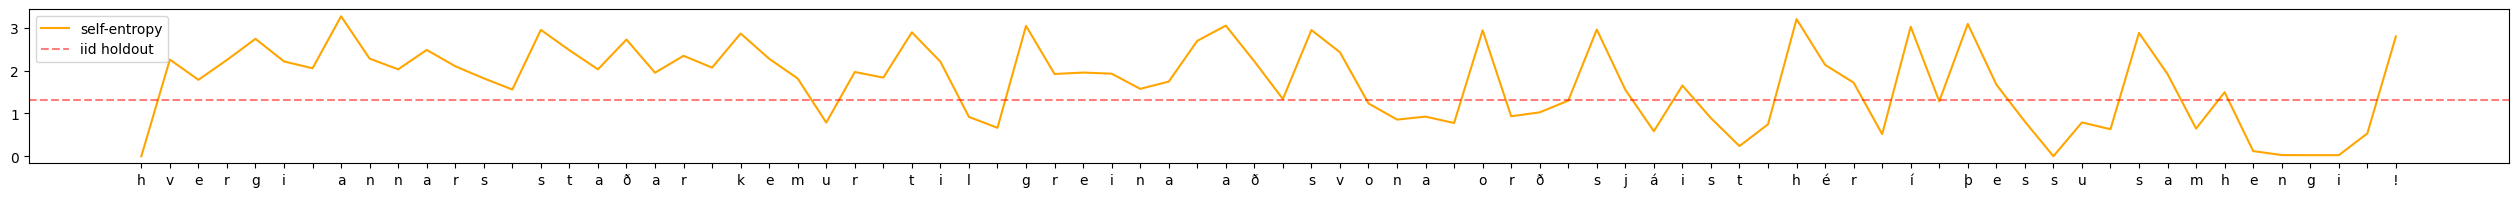

In [4]:
plt.figure(figsize=fig_size)
plt.plot(char_positions, char_entropies, label="self-entropy", color="orange")
plt.axhline(y=1.320, color="r", linestyle="--", label="iid holdout", alpha=0.5)
plt.xticks(char_positions, char_sequence)
plt.legend()
plt.legend()
plt.show()

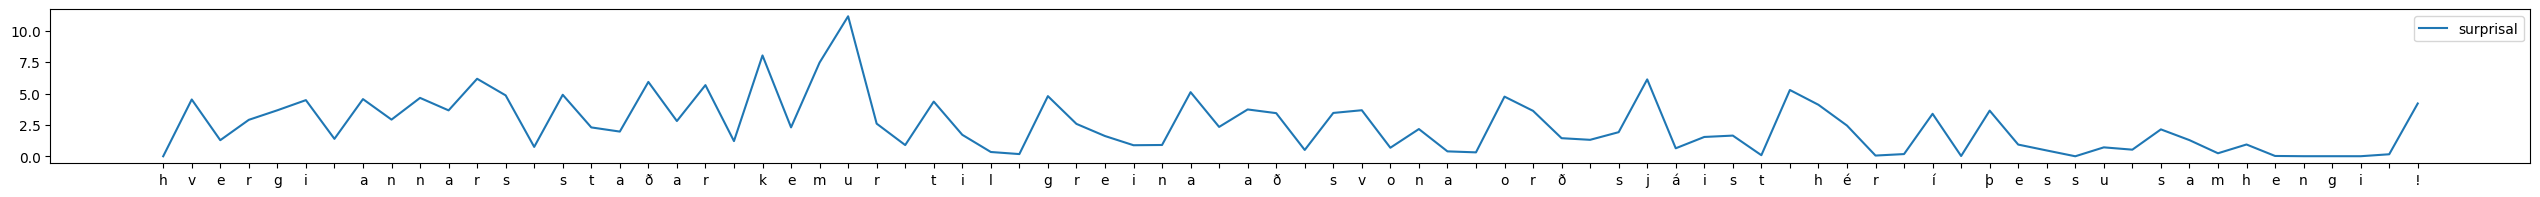

In [5]:
plt.figure(figsize=fig_size)
plt.plot(char_positions, char_surprisals, label="surprisal")
plt.xticks(char_positions, char_sequence)
plt.legend()
plt.show()

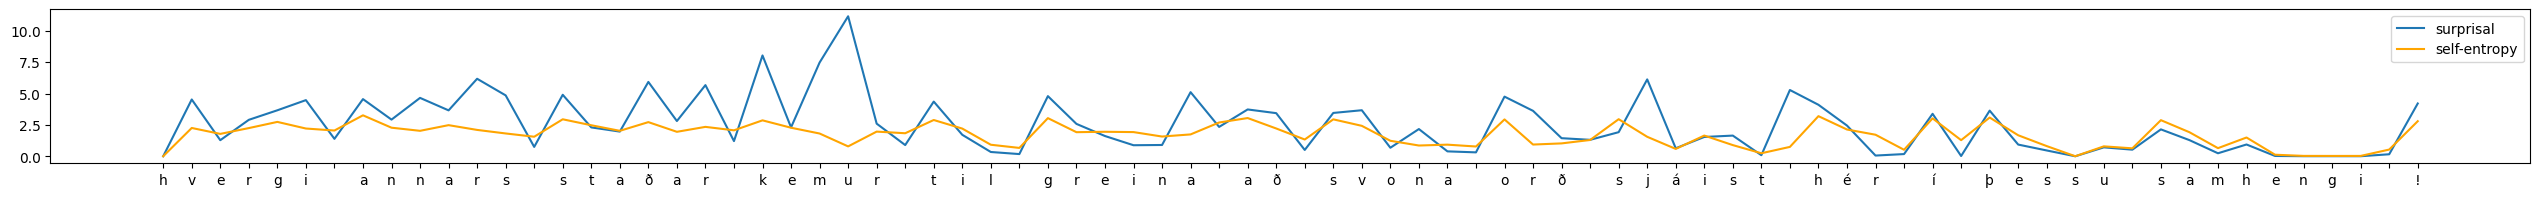

In [6]:
plt.figure(figsize=fig_size)
plt.plot(char_positions, char_surprisals, label="surprisal")
plt.plot(char_positions, char_entropies, label="self-entropy", color="orange")
plt.xticks(char_positions, char_sequence)
plt.legend()
plt.legend()
plt.show()

In [7]:
start_ends = [
    (0, 6),
    (6, 7),
    (7, 13),
    (13, 14),
    (14, 20),
    (20, 21),
    (21, 26),
    (26, 27),
    (27, 30),
    (30, 31),
]
for start, end_window in start_ends:
    total_surp = char_surprisals[start:end_window].sum()
    substring = "".join(char_sequence[start:end_window])
    nchars = len(substring)
    substring = f"'{substring}'"
    bit_rate = total_surp / nchars
    print(f"{total_surp:>4.1f}  {substring:<20s}    {nchars} chars, ~{bit_rate:<4.1f} bits/char")

16.9  'hvergi'                6 chars, ~2.8  bits/char
 1.4  ' '                     1 chars, ~1.4  bits/char
26.8  'annars'                6 chars, ~4.5  bits/char
 0.7  ' '                     1 chars, ~0.7  bits/char
23.6  'staðar'                6 chars, ~3.9  bits/char
 1.2  ' '                     1 chars, ~1.2  bits/char
31.6  'kemur'                 5 chars, ~6.3  bits/char
 0.9  ' '                     1 chars, ~0.9  bits/char
 6.4  'til'                   3 chars, ~2.1  bits/char
 0.2  ' '                     1 chars, ~0.2  bits/char


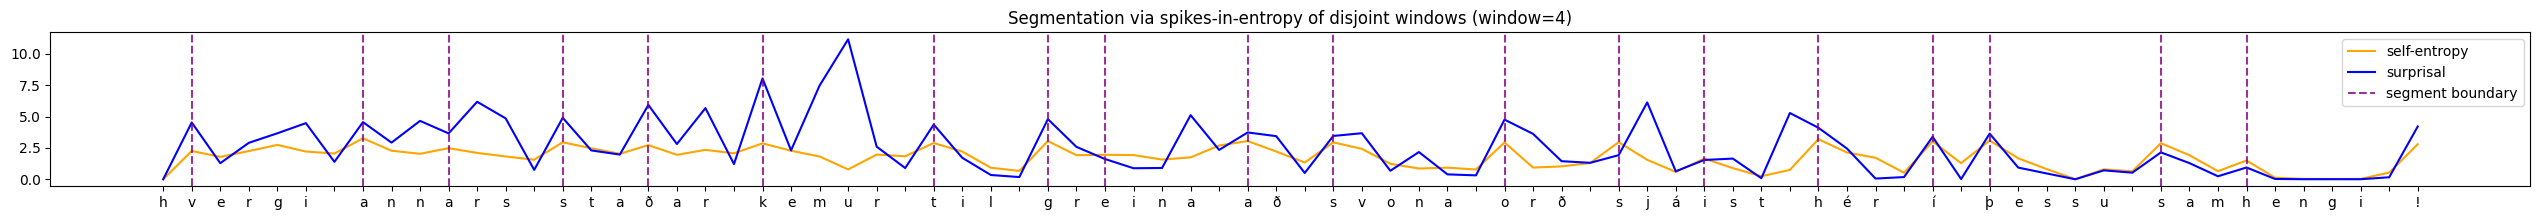

In [8]:
window_len = 4
# char_entropies
spike_locs = []
window_offsets = list(range(0, len(char_entropies) - window_len, window_len))
for offset in window_offsets:
    end_window = offset + window_len
    rel_offset = char_entropies[offset:end_window].argmax()
    abs_offset = offset + rel_offset
    spike_locs.append(abs_offset)

# make same plot as the entropy plot, but also include vertical lines at the spike locations
plt.figure(figsize=fig_size)
# line-plot of entropies
plt.plot(char_positions, char_entropies, label="self-entropy", color="orange")
# line-plot of surprisals
plt.plot(char_positions, char_surprisals, label="surprisal", color="blue")
# vertical lines at the spike locations
plt.axvline(x=spike_locs[0], color="purple", linestyle="--", label="segment boundary", alpha=0.8)

# add legend
plt.legend()
# add title
plt.title(f"Segmentation via spikes-in-entropy of disjoint windows (window={window_len})")

# we don't repeated legends for the spikes
for spike_loc in spike_locs[1:]:
    plt.axvline(x=spike_loc, color="purple", linestyle="--", label="spike", alpha=0.8)

# change x-axis to show character positions (and the character sequence)
plt.xticks(char_positions, char_sequence)
plt.show()